## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, precision_score, \
    recall_score, f1_score, roc_auc_score, make_scorer, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Разделение на тренировачный и тестовый наборы

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9254,9255,15601116,P'an,686,France,Male,32,6,0.00,2,1,1,179093.26,0
1561,1562,15766374,Leak,632,Germany,Male,42,4,119624.60,2,1,1,195978.86,0
1670,1671,15716994,Green,559,Spain,Male,24,3,114739.92,1,1,0,85891.02,1
6087,6088,15730759,Chukwudi,561,France,Female,27,9,135637.00,1,1,0,153080.40,1
6669,6670,15797900,Chinomso,517,France,Male,56,9,142147.32,1,0,0,39488.04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,5735,15596647,Henderson,768,France,Male,54,8,69712.74,1,1,1,69381.05,0
5191,5192,15681075,Chukwualuka,682,France,Female,58,1,0.00,1,1,1,706.50,0
5390,5391,15573851,Macrossan,735,France,Female,38,1,0.00,3,0,0,92220.12,1
860,861,15807663,McGregor,667,France,Male,43,8,190227.46,1,1,0,97508.04,1


## Беглый взгляд на структуру данных

**Удалим RowNumber, CustomerId и Surname, так как очевидно, что от этих атрибутов целевой признак не должен зависеть**

In [4]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.shape

(10000, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


*Из df.info() видно, что данный датасет не имеет пропусков. Geography и Gender вероятно представляют собой категориальные атрибуты. Посмотрим какие категории существуют*

In [7]:
df_train['Geography'].value_counts()

France     3994
Germany    2011
Spain      1995
Name: Geography, dtype: int64

In [8]:
df_train['Gender'].value_counts()

Male      4362
Female    3638
Name: Gender, dtype: int64

In [9]:
df_train.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5012.506875,1.569067e+07,651.647625,38.897750,5.003875,76102.139645,1.531375,0.703500,0.512750,100431.289764,0.205500
std,2887.649416,7.184743e+04,96.366200,10.518953,2.881822,62461.005757,0.579705,0.456743,0.499869,57518.920431,0.404092
min,2.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.000000
25%,2512.750000,1.562822e+07,585.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51364.125000,0.000000
50%,5014.500000,1.569074e+07,653.000000,37.000000,5.000000,96447.520000,1.000000,1.000000,1.000000,100487.720000,0.000000
75%,7505.250000,1.575316e+07,719.000000,44.000000,7.000000,127611.332500,2.000000,1.000000,1.000000,149595.842500,0.000000
max,10000.000000,1.581566e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000,1.000000


In [10]:
df_train.shape

(8000, 14)

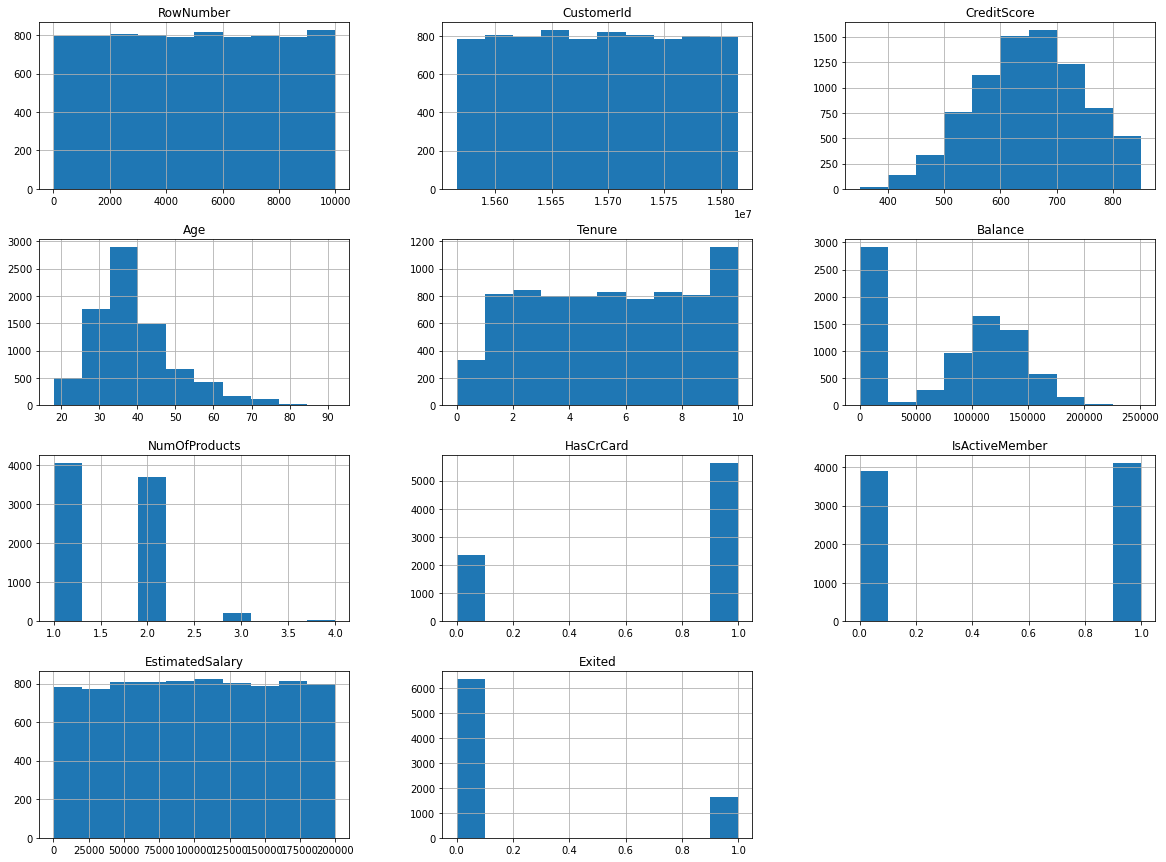

In [11]:
df_train.hist(figsize=(20, 15))
None

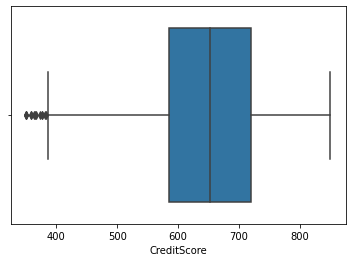

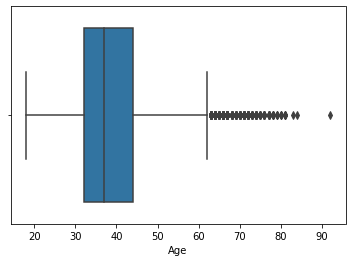

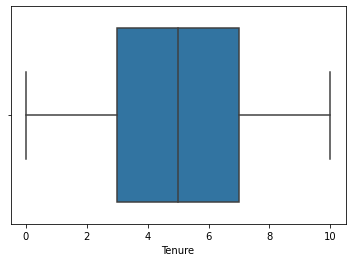

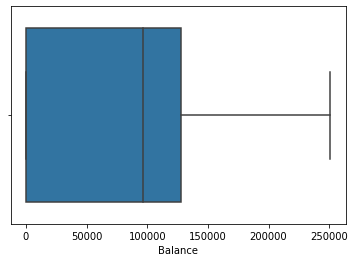

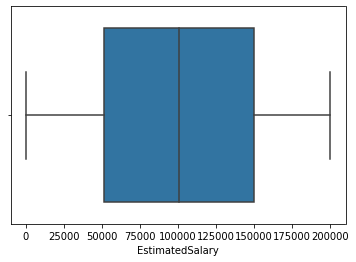

In [12]:
for attr_name in ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']:
    sns.boxplot(x=df_train[attr_name])
    plt.show()

CreditScore и Age имеют выбросы

## Заменим выбросы на nan

In [13]:
for x in ['CreditScore', 'Age']:
    q75, q25 = np.percentile(df_train.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df_train.loc[df_train[x] < min,x] = np.nan
    df_train.loc[df_train[x] > max,x] = np.nan
df_train.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore         13
Geography            0
Gender               0
Age                286
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

nan значений не так много, поэтому можно их удалить

In [14]:
df_train = df_train.dropna(axis = 0)
df_train.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [15]:
df_train.shape

(7701, 14)

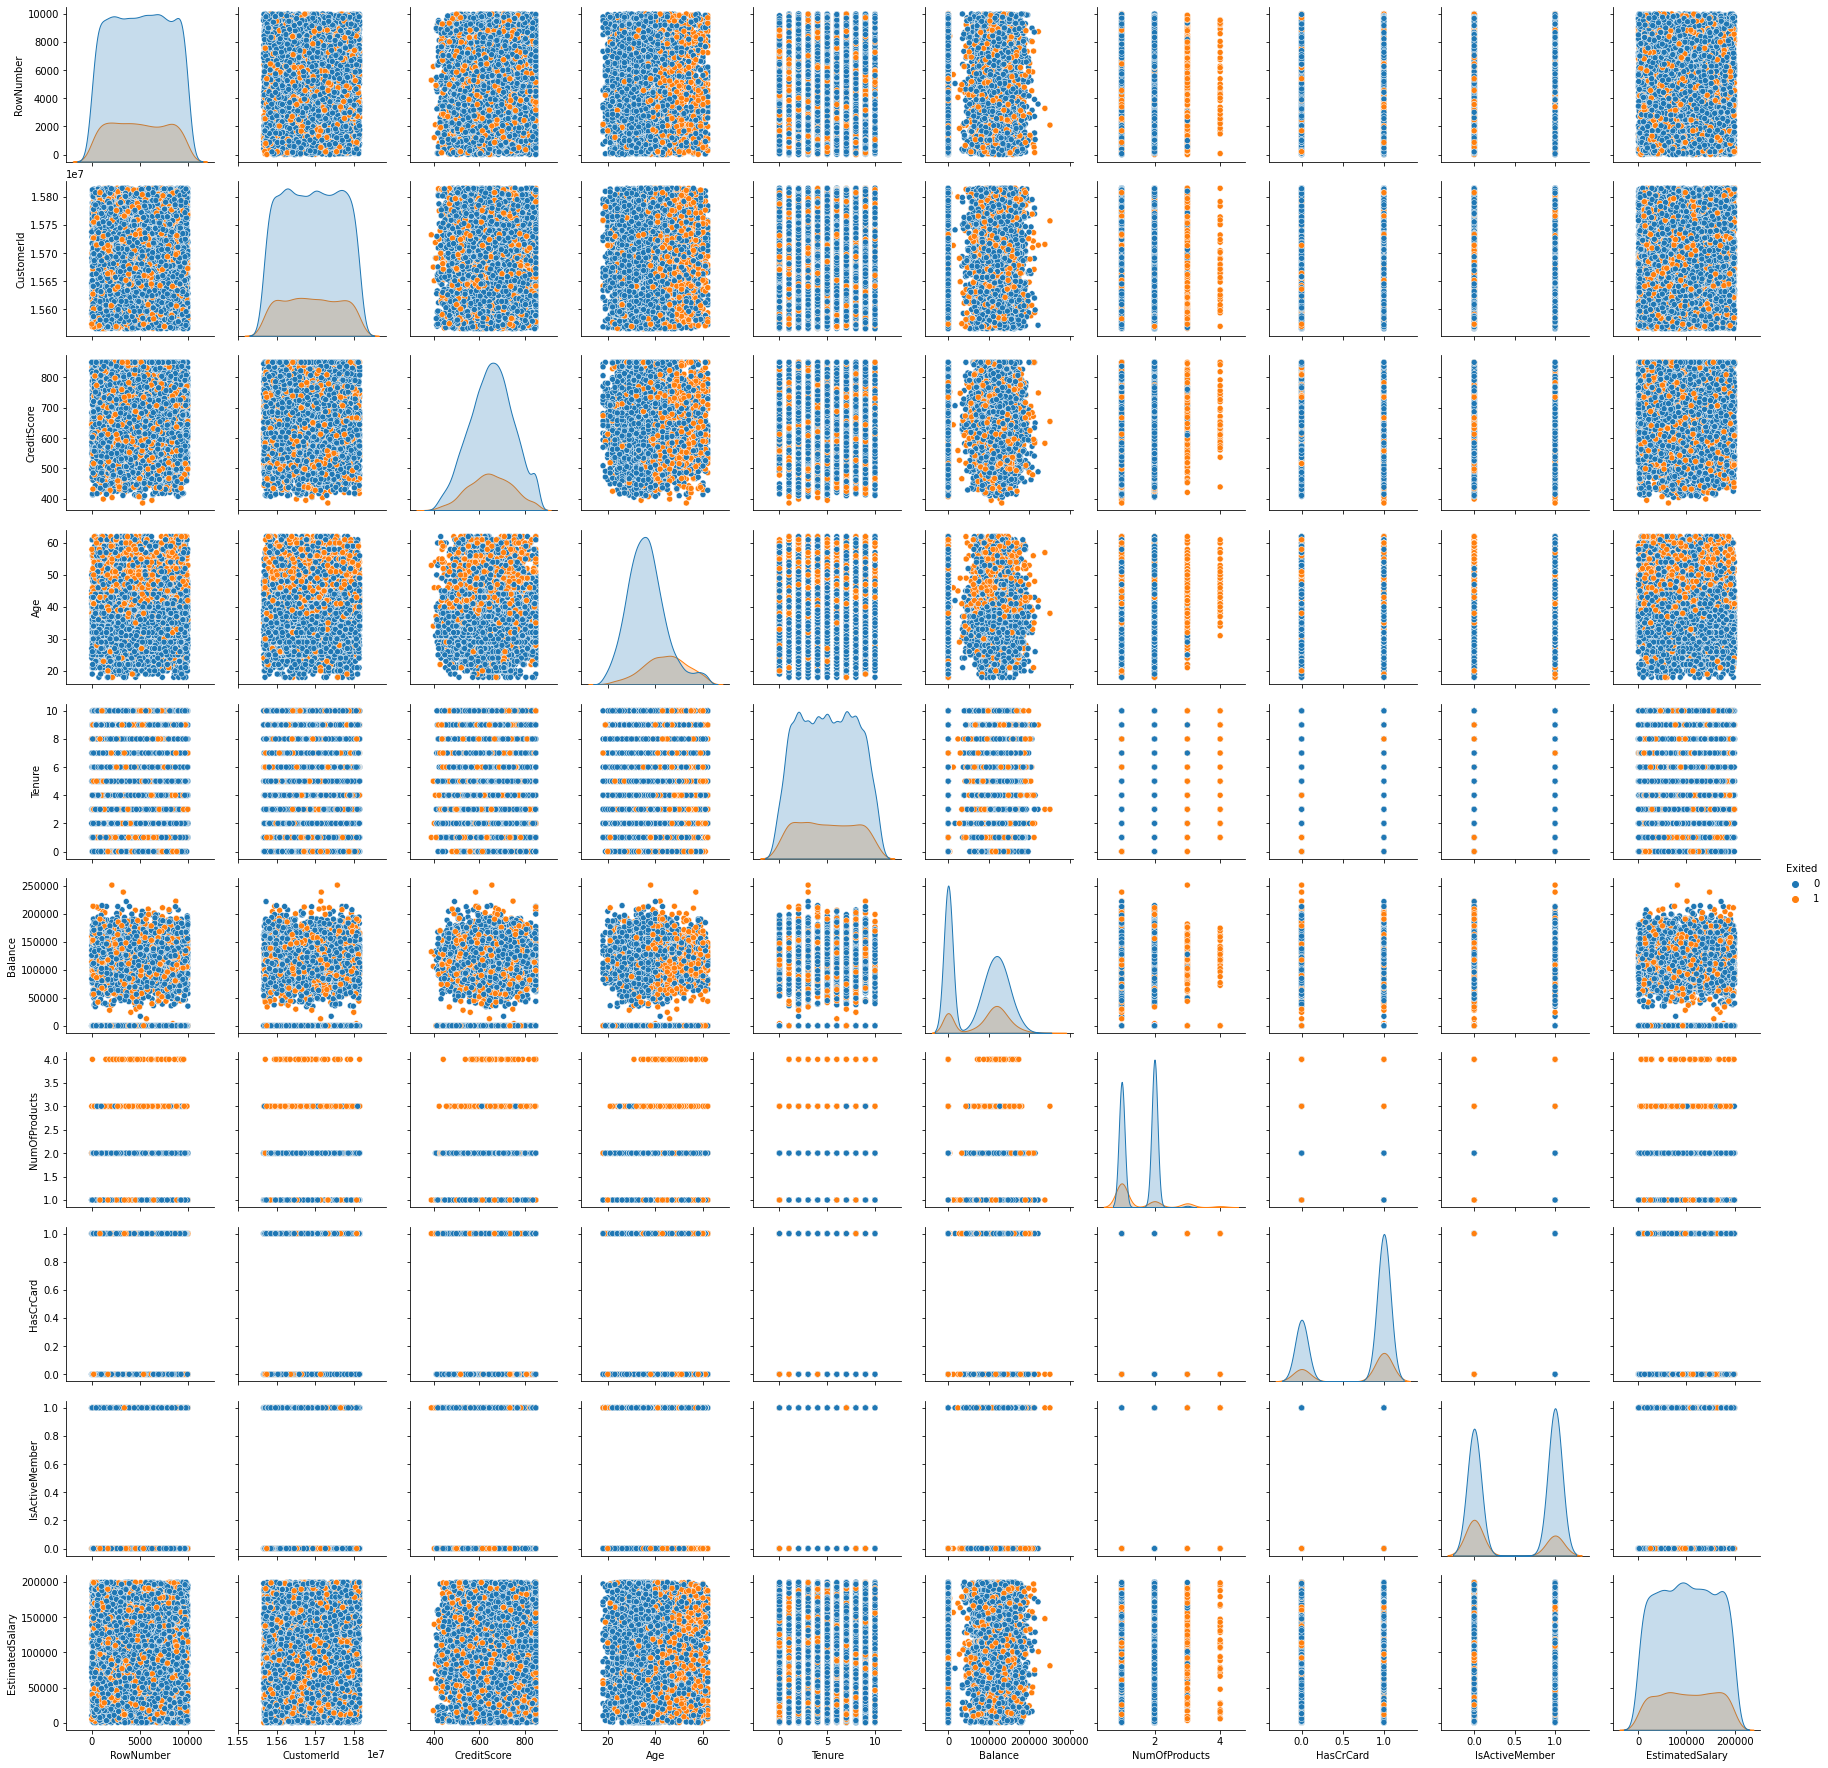

In [16]:
sns.pairplot(df_train, hue='Exited')
None

## Поиск связей

In [17]:
corr_mattr = df_train.corr()
corr_mattr

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.005878,-0.007233,-0.008514,-0.000881,-0.010648,0.005527,0.000689,0.009539,-0.012528,-0.018279
CustomerId,0.005878,1.000000,0.016490,0.013629,-0.015322,-0.008220,0.010639,-0.014509,-0.002924,0.014338,-0.002775
CreditScore,-0.007233,0.016490,1.000000,-0.016523,-0.008537,0.006510,0.019610,-0.008477,0.021951,0.001379,-0.017611
Age,-0.008514,0.013629,-0.016523,1.000000,-0.010514,0.045130,-0.032847,-0.020601,0.017932,0.002740,0.358666
Tenure,-0.000881,-0.015322,-0.008537,-0.010514,1.000000,-0.013292,0.018713,0.019159,-0.022784,0.024440,-0.012706
Balance,-0.010648,-0.008220,0.006510,0.045130,-0.013292,1.000000,-0.297568,-0.013218,-0.018148,0.009267,0.116735
NumOfProducts,0.005527,0.010639,0.019610,-0.032847,0.018713,-0.297568,1.000000,0.003292,0.022913,0.011952,-0.053277
HasCrCard,0.000689,-0.014509,-0.008477,-0.020601,0.019159,-0.013218,0.003292,1.000000,-0.012272,-0.013435,-0.005988
IsActiveMember,0.009539,-0.002924,0.021951,0.017932,-0.022784,-0.018148,0.022913,-0.012272,1.000000,-0.007545,-0.143474
EstimatedSalary,-0.012528,0.014338,0.001379,0.002740,0.024440,0.009267,0.011952,-0.013435,-0.007545,1.000000,0.007386


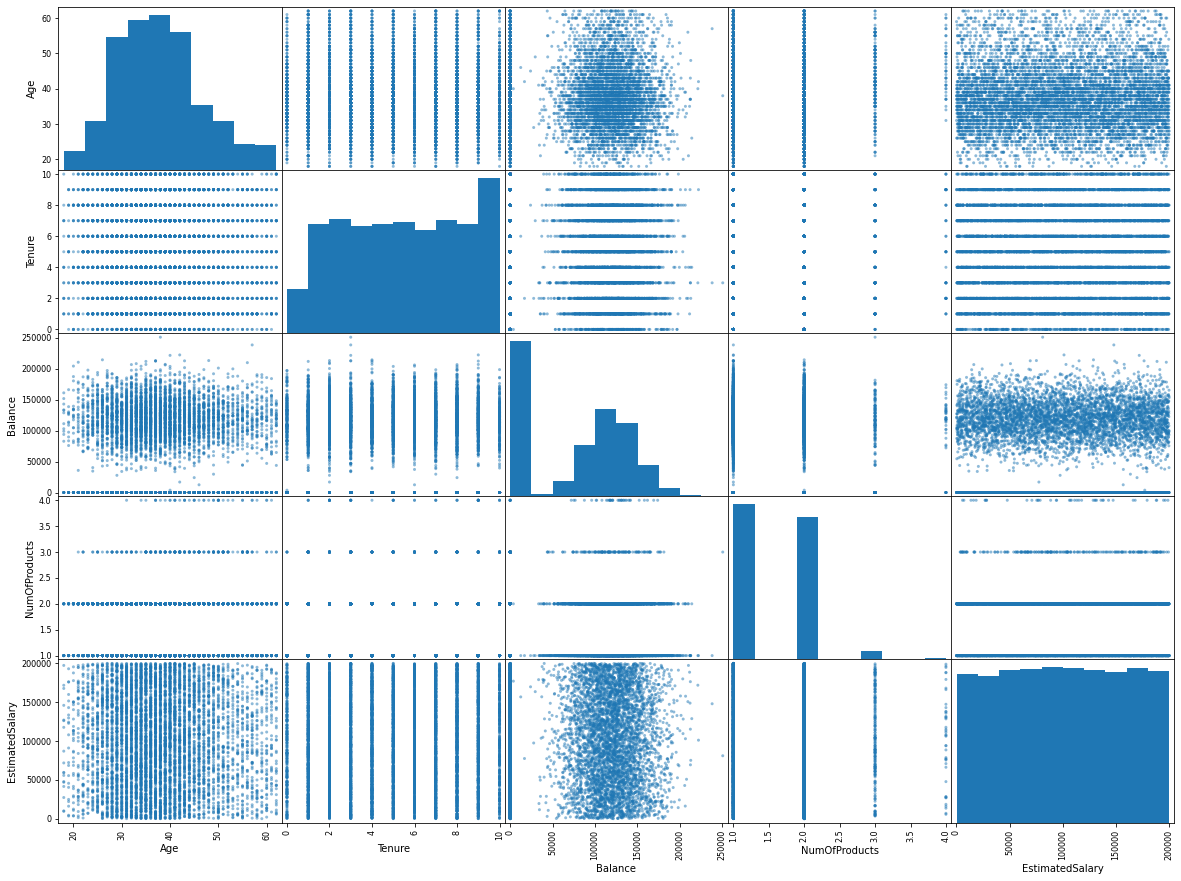

In [18]:
pd.plotting.scatter_matrix(df_train[['Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']], figsize=(20, 15))
None

## Подготовка данных

### Обработка текстовых и категориальных атрибутов

In [19]:
class DataSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attributes].values

In [20]:
num_attr = ['CreditScore', 'Balance', 'EstimatedSalary']
cat_attr = ['Geography', 'Gender']

num_pipeline = Pipeline([
    ('num_selector', DataSelector(num_attr)),
    ('num_standard_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_selector', DataSelector(cat_attr)),
    ('cat_encoder', OneHotEncoder())
])

others_pipeline = Pipeline([
    ('others_attr', DataSelector(df.drop(num_attr+cat_attr, axis=1).columns))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
    ('others_pipeline', others_pipeline)
])

In [21]:
df_train_transform = full_pipeline.fit_transform(df_train)
df_train_prepared = df_train_transform.toarray()
df_train_prepared

array([[ 0.35565783, -1.2205186 ,  1.36679422, ...,  1.        ,
         1.        ,  0.        ],
       [-0.20794051,  0.69424611,  1.66028733, ...,  1.        ,
         1.        ,  0.        ],
       [-0.96984198,  0.61605974, -0.25317874, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.86707114, -1.2205186 , -0.14317096, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.15735471,  1.82434697, -0.05126022, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.4704649 ,  1.14699964, -0.81476537, ...,  1.        ,
         1.        ,  0.        ]])

In [22]:
df_train_prepared.shape

(7701, 14)

## Выбор и обучение модели

**Разделение тренировачной части на X и y**

In [23]:
X_train = df_train_prepared[:,:-1]
X_train

array([[ 0.35565783, -1.2205186 ,  1.36679422, ...,  2.        ,
         1.        ,  1.        ],
       [-0.20794051,  0.69424611,  1.66028733, ...,  2.        ,
         1.        ,  1.        ],
       [-0.96984198,  0.61605974, -0.25317874, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 0.86707114, -1.2205186 , -0.14317096, ...,  3.        ,
         0.        ,  0.        ],
       [ 0.15735471,  1.82434697, -0.05126022, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.4704649 ,  1.14699964, -0.81476537, ...,  1.        ,
         1.        ,  1.        ]])

In [24]:
y_train = df_train_prepared[:, -1]
y_train

array([0., 0., 1., ..., 1., 1., 0.])

**Выполним решетчатый поиск для подбора гиперпараметров для логистической регрессии**

In [25]:
params = {'C': [0.1, 1, 10, 100], 'class_weight': ['balanced', None], 'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'tol': [1e-4, 1e-3, 1e-2, 0.1]}
logistic_clf = LogisticRegression(max_iter=300)
roc_auc = make_scorer(roc_auc_score)
cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_logistic = GridSearchCV(logistic_clf, param_grid=params, cv=cross_validation, scoring=roc_auc)
grid_logistic.fit(X_train, y_train)
best_logistic_clf = grid_logistic.best_estimator_
grid_logistic.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs', 'tol': 0.0001}


**Суммы оценок**

In [26]:
def print_clfs_params(cv_res):
    for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
        print(mean_score, params)

In [27]:
print_clfs_params(grid_logistic.cv_results_)

0.7203029522847748 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'newton-cg', 'tol': 0.0001}
0.7203029522847748 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'newton-cg', 'tol': 0.001}
0.7203029522847748 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'newton-cg', 'tol': 0.01}
0.7203029522847748 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'newton-cg', 'tol': 0.1}
0.7208652439768729 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs', 'tol': 0.0001}
0.7208652439768729 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs', 'tol': 0.001}
0.7208652439768729 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs', 'tol': 0.01}
0.7208652439768729 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs', 'tol': 0.1}
0.7159137952081323 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear', 'tol': 0.0001}
0.7159137952081323 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear', 'tol': 0.001}
0.71518810504082 {'C': 0.1, 'class_weight': 'balanced', 'solver': 'li

## Предсказание модели на тренировочной выборке

In [28]:
y_logistic_clf_pred = best_logistic_clf.predict(X_train)
y_logistic_clf_pred_decision = best_logistic_clf.decision_function(X_train)

## Показатели производительности

In [29]:
def plot_precision_recall(y_true, y_pred_decision):
    precisions_logistic, recall_logistic, thresholds_logistic = precision_recall_curve(y_true, y_pred_decision)
    plt.rcParams['figure.figsize'] = (10, 5)
    plt.plot(thresholds_logistic, precisions_logistic[:-1], 'b--', label='precisions')
    plt.plot(thresholds_logistic, recall_logistic[:-1], 'g-', label='recall')
    plt.xlabel('thresholds')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

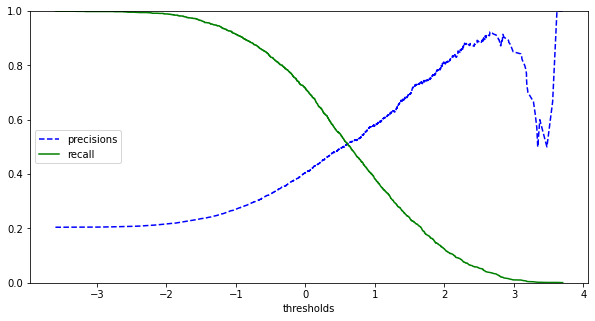

In [30]:
plot_precision_recall(y_train, y_logistic_clf_pred_decision)
None

In [31]:
def print_scores(y_true, y_pred):
    print('%15s' % 'precision: ', f'{precision_score(y_true, y_pred):>5.3f}')
    print('%15s' % 'recall: ', f'{recall_score(y_true, y_pred):>5.3f}')
    print('%15s' % 'f1: ', f'{f1_score(y_true, y_pred):>5.3f}')
    print('%15s' % 'accuracy: ', f'{accuracy_score(y_true, y_pred):>5.3f}')
    print('%15s' % 'roc_auc: ', f'{roc_auc_score(y_true, y_pred):>5.3f}')

In [32]:
print_scores(y_train, y_logistic_clf_pred)

    precision:  0.405
       recall:  0.716
           f1:  0.517
     accuracy:  0.727
      roc_auc:  0.723


In [33]:
def plot_roc(y_true, y_pred_decision):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_decision)
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

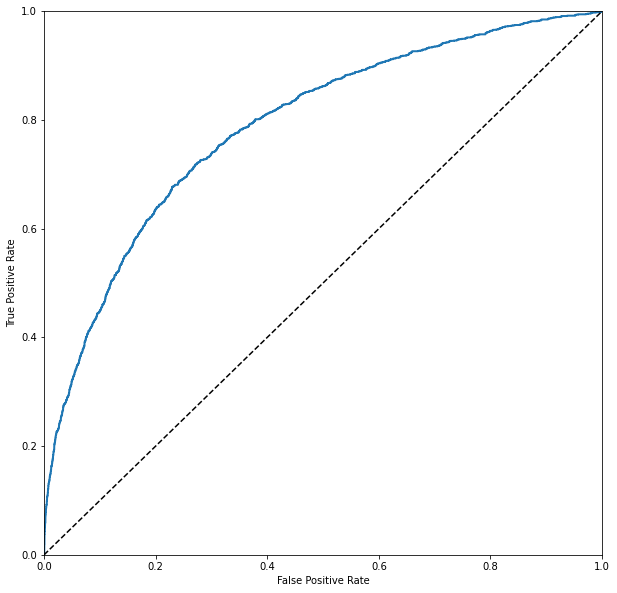

In [34]:
plot_roc(y_train, y_logistic_clf_pred_decision)

## Прогноз на тестовой выборке

In [35]:
df_test_transform = full_pipeline.fit_transform(df_test)
df_test_prepared = df_test_transform.toarray()
X_test = df_test_prepared[:, :-1]
y_test = df_test_prepared[:, -1]
y_logistic_clf_pred_test = best_logistic_clf.predict(X_test)
y_logistic_clf_pred_decision_test = best_logistic_clf.decision_function(X_test)

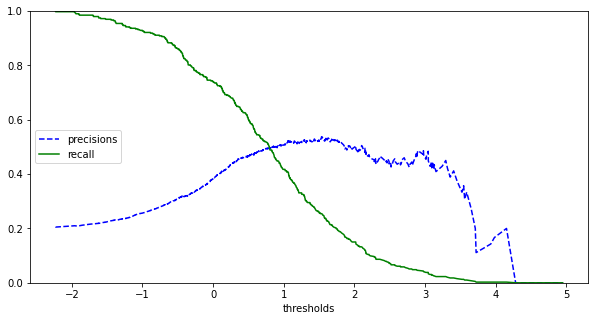

In [36]:
plot_precision_recall(y_test, y_logistic_clf_pred_decision_test)

In [37]:
print_scores(y_test, y_logistic_clf_pred_test)

    precision:  0.383
       recall:  0.738
           f1:  0.504
     accuracy:  0.715
      roc_auc:  0.724


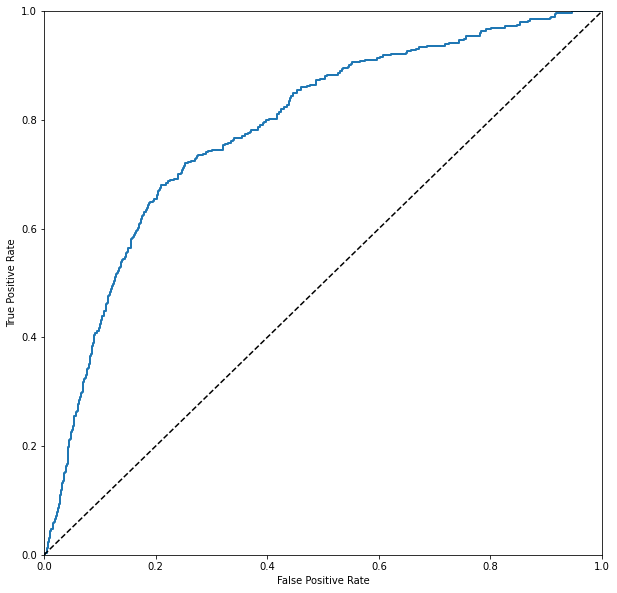

In [38]:
plot_roc(y_test, y_logistic_clf_pred_decision_test)

## Бустинг

**Подбор гиперпараметров и обучение модели**

In [39]:
params_gb = {
    'loss': ['deviance'],
    'learning_rate': np.linspace(1e-4, 1, num=5),
    'subsample': np.arange(0.25, 1, 0.25),
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': np.linspace(0.1, 1.0, 5),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [500]
}
boosting_clf = GradientBoostingClassifier()
grid_boosting = GridSearchCV(boosting_clf, param_grid=params_gb, scoring=roc_auc, cv=5, n_jobs=-1)
grid_boosting.fit(X_train, y_train)
best_gb_clf = grid_boosting.best_estimator_
grid_boosting.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.250075,
 'loss': 'deviance',
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 500,
 'subsample': 0.75}

In [40]:
print_clfs_params(grid_boosting.cv_results_)

0.5 {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 500, 'subsample': 0.25}
0.5 {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 500, 'subsample': 0.5}
0.5 {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 500, 'subsample': 0.75}
0.5 {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.325, 'n_estimators': 500, 'subsample': 0.25}
0.5 {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.325, 'n_estimators': 500, 'subsample': 0.5}
0.5 {'criterion': 'friedman_

## Прогноз и оценивание на тренировочной выборке

In [41]:
y_gb_clf_pred = best_gb_clf.predict(X_train)
y_gb_clf_pred_decision = best_gb_clf.decision_function(X_train)

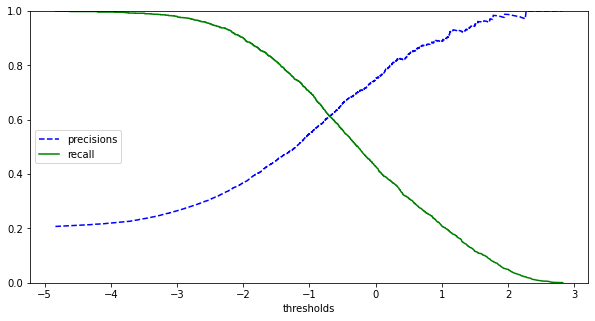

In [42]:
plot_precision_recall(y_train, y_gb_clf_pred_decision)

In [43]:
print_scores(y_train, y_gb_clf_pred)

    precision:  0.750
       recall:  0.427
           f1:  0.544
     accuracy:  0.854
      roc_auc:  0.695


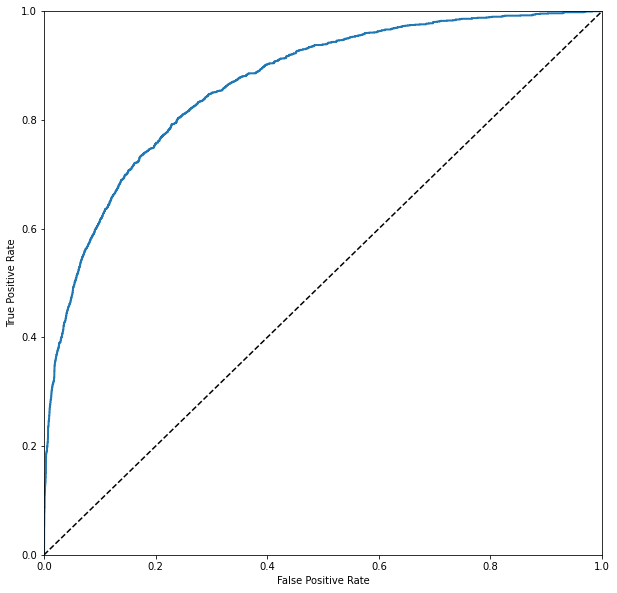

In [44]:
plot_roc(y_train, y_gb_clf_pred_decision)

## Прогноз и оценивание на тестовой выборке

In [45]:
y_gb_clf_pred_test = best_gb_clf.predict(X_test)
y_gb_clf_pred_decision_test = best_gb_clf.decision_function(X_test)

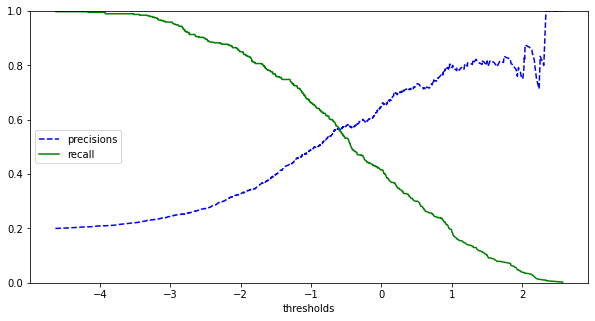

In [46]:
plot_precision_recall(y_test, y_gb_clf_pred_decision_test)

In [47]:
print_scores(y_test, y_gb_clf_pred_test)

    precision:  0.649
       recall:  0.415
           f1:  0.506
     accuracy:  0.841
      roc_auc:  0.680


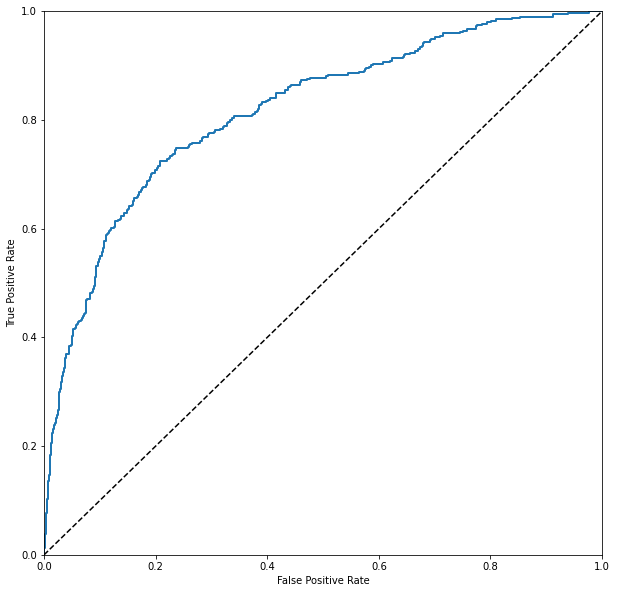

In [48]:
plot_roc(y_test, y_gb_clf_pred_decision_test)

## Вывод

В работе была проделана обработка данных (стандартизация и обработка категориальных признаков), для автоматизации использовались pipeline. Обучили две модели: логистическая регрессия и ансамбль деревьев решений с применением градиентного бустинга. Для подбора гиперпараметров использовалась функция GridSearchCV. Данные действия повлияли на качество моделей. По результатам roc_auc лучше показала себя логистическая регрессия. Стоит отметить, что выбор гиперпарметров и обучение ансамбля деревьев занимает больше времени.